# Task 1
Start with the most basic: beta. Explore the implications of the concentration of the
seven in the S&P 500 (which is often used as the proxy for the market). How much of
the beta is driven by the seven verses the 493 other stocks (i.e. they probably have
different betas – think three)? How does this affect the use of beta for
evaluating/forecasting returns and the use of beta for investment decisions? What
happens if there is a significant change in the price of one or more of those
securities (especially since there may be significant interdependence due to the
growth of AI investment by many of those firms)? Does the 2024 drop in Tesla reveal
anything? Is that dispositive?

## Importing Libraries & dependancies

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import arch
from arch import arch_model
from pykalman import KalmanFilter

#### We got the historical beta data for all Mag7 stocks and SPW Index from Bloomberg

In [6]:
file_paths = glob.glob("updatedhistoricalbetas/*.xlsx")  # Change 'path_to_excels/' to the actual directory


In [8]:
dfs = []

In [13]:
for file in file_paths:
    df = pd.read_excel(file)  # Read Excel file
    df["Date"] = pd.to_datetime(df["Date"])  # Convert Date column to datetime
    filename = os.path.basename(file)
    ticker = filename.replace("vsspx", "").replace(".xlsx", "").upper()  # AAPL, AMZN, etc.

    
    
    # Select only relevant columns and rename them to avoid conflicts
    df = df[["Date", f"{ticker} US Equity - Fitted"]]
    df.rename(columns={f"{ticker} US Equity - Fitted": ticker}, inplace=True)
    
    # Store the cleaned dataframe
    dfs.append(df)

In [15]:
combined_df = dfs[0]
for df in dfs[1:]:
    combined_df = combined_df.merge(df, on="Date", how="inner")

## Visualizing and doing preliminary analysis

In [17]:
combined_df.head()

,Date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,SPW,TSLA
0,2025-02-14,0.034,0.018,0.019,0.055,0.0082,0.1897,-0.02,0.1344
1,2025-02-13,1.258,1.164,1.209,1.422,1.2390,2.0546,1.01,1.7995
2,2025-02-12,-0.275,-0.271,-0.282,-0.290,-0.3027,-0.2814,-0.28,-0.2862
3,2025-02-11,0.082,0.063,0.065,0.109,0.0564,0.2628,0.02,0.1997
4,2025-02-10,0.825,0.759,0.788,0.939,0.8036,1.3949,0.65,1.2105


In [19]:
combined_df.tail()

,Date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,SPW,TSLA
1310,2020-02-07,-0.587,-0.563,-0.586,-0.639,-0.6166,-0.7569,-0.54,-0.7108
1311,2020-02-06,0.430,0.389,0.404,0.498,0.4065,0.7933,0.31,0.6733
1312,2020-02-05,1.354,1.254,1.302,1.530,1.3356,2.2010,1.09,1.9303
1313,2020-02-04,1.789,1.660,1.725,2.016,1.7729,2.8636,1.46,2.5218
1314,2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
combined_df["Date"] = pd.to_datetime(combined_df["Date"])

In [23]:
combined_df.set_index("Date", inplace=True)

### Actual index weights, as of Jaunrary 2025

In [270]:
m7_weights = {
    "AAPL": 0.0704, 
    "GOOGL": 0.0382,
    "META": 0.0306,
    "NVDA": 0.064,
    "AMZN": 0.0416,
    "MSFT": 0.0588,
    "TSLA": 0.0192,
}

In [27]:
w_m7 = sum(m7_weights.values())

In [29]:
print(w_m7)

0.3228


In [224]:
m7_tickers = ["AAPL", "GOOGL", "META", "NVDA", "AMZN", "MSFT", "TSLA"]

In [33]:
combined_df["Beta_M7_Weighted"] = sum(combined_df[ticker] * m7_weights[ticker] for ticker in m7_tickers)

In [35]:
combined_df["Beta_493"] = combined_df["SPW"]  # Using the provided beta

In [37]:
w_493 = 1 - w_m7

In [39]:
combined_df["Beta_SP500"] = (w_m7 * combined_df["Beta_M7_Weighted"]) + (w_493 * combined_df["Beta_493"])

In [41]:
combined_df.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,SPW,TSLA,Beta_M7_Weighted,Beta_493,Beta_SP500
Date,,,,,,,,,,,
2025-02-14,0.034,0.018,0.019,0.055,0.0082,0.1897,-0.02,0.1344,0.020755,-0.02,-0.006844
2025-02-13,1.258,1.164,1.209,1.422,1.2390,2.0546,1.01,1.7995,0.465581,1.01,0.834261
2025-02-12,-0.275,-0.271,-0.282,-0.290,-0.3027,-0.2814,-0.28,-0.2862,-0.091583,-0.28,-0.219179
2025-02-11,0.082,0.063,0.065,0.109,0.0564,0.2628,0.02,0.1997,0.038182,0.02,0.025869
2025-02-10,0.825,0.759,0.788,0.939,0.8036,1.3949,0.65,1.2105,0.308256,0.65,0.539685


In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1315 entries, 2025-02-14 to 2020-02-03
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AAPL              1266 non-null   float64
 1   AMZN              1266 non-null   float64
 2   GOOGL             1266 non-null   float64
 3   META              1266 non-null   float64
 4   MSFT              1266 non-null   float64
 5   NVDA              1266 non-null   float64
 6   SPW               1266 non-null   float64
 7   TSLA              1266 non-null   float64
 8   Beta_M7_Weighted  1266 non-null   float64
 9   Beta_493          1266 non-null   float64
 10  Beta_SP500        1266 non-null   float64
dtypes: float64(11)
memory usage: 123.3 KB


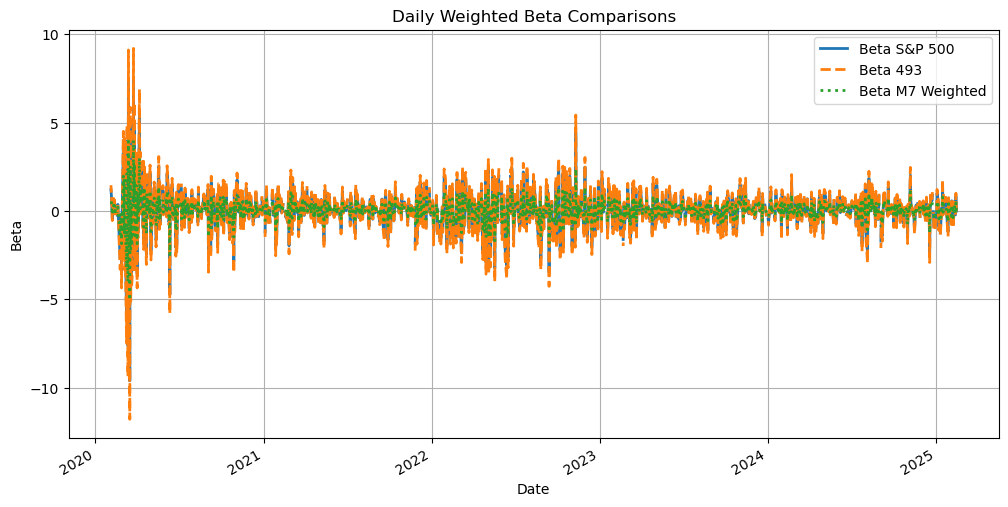

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

combined_df["Beta_SP500"].plot(ax=ax, label="Beta S&P 500", linewidth=2)
combined_df["Beta_493"].plot(ax=ax, label="Beta 493", linestyle="--", linewidth=2)
combined_df["Beta_M7_Weighted"].plot(ax=ax, label="Beta M7 Weighted", linestyle=":", linewidth=2)

# Formatting
ax.set_title("Daily Weighted Beta Comparisons")
ax.set_ylabel("Beta")
ax.grid(True)
ax.legend()  # Add a legend to differentiate lines

# Show plot
plt.show()

### Visualising how the betas move in our time range

### We did use the Bloomberg historical betas, we there we have no control on the betas are calculated so we will recalculate betas using 3 distnct methods and then choose 1 from and then proceed to our task

### As getting proper data is very essential for our task, we are going to alternated approach to ensure that we use validated data

In [47]:
dfs = []

In [49]:
for file in file_paths:
    df = pd.read_excel(file)  # Read Excel file
    df["Date"] = pd.to_datetime(df["Date"])  # Convert Date column to datetime
    filename = os.path.basename(file)
    ticker = filename.replace("vsspx", "").replace(".xlsx", "").upper()  # AAPL, AMZN, etc.

    
    
    # Select only relevant columns and rename them to avoid conflicts
    df = df[["Date", f"{ticker} US Equity - Percent"]]
    df.rename(columns={f"{ticker} US Equity - Percent": ticker}, inplace=True)
    
    # Store the cleaned dataframe
    dfs.append(df)

In [50]:
combined_pct_df = dfs[0]
for df in dfs[1:]:
    combined_pct_df = combined_pct_df.merge(df, on="Date", how="inner")

In [53]:
combined_pct_df["Date"] = pd.to_datetime(combined_pct_df["Date"])

In [55]:
combined_pct_df.set_index("Date", inplace=True)

In [57]:
combined_pct_df = combined_pct_df.dropna()


In [59]:
combined_pct_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1266 entries, 2025-02-14 to 2020-02-04
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1266 non-null   float64
 1   AMZN    1266 non-null   float64
 2   GOOGL   1266 non-null   float64
 3   META    1266 non-null   float64
 4   MSFT    1266 non-null   float64
 5   NVDA    1266 non-null   float64
 6   SPW     1266 non-null   float64
 7   TSLA    1266 non-null   float64
dtypes: float64(8)
memory usage: 89.0 KB


In [61]:
ROLLING_WINDOW = 60

In [63]:
rolling_betas = pd.DataFrame(index=combined_pct_df.index, columns=m7_tickers)

In [65]:
for ticker in m7_tickers:
    for i in range(ROLLING_WINDOW, len(combined_pct_df)):
        window_data = combined_pct_df.iloc[i-ROLLING_WINDOW:i]  # Rolling window subset
        X = sm.add_constant(window_data["SPW"])  # Market return with intercept
        y = window_data[ticker]  # Stock return

        model = sm.OLS(y, X).fit()
        rolling_betas.at[combined_pct_df.index[i], ticker] = model.params["SPW"]

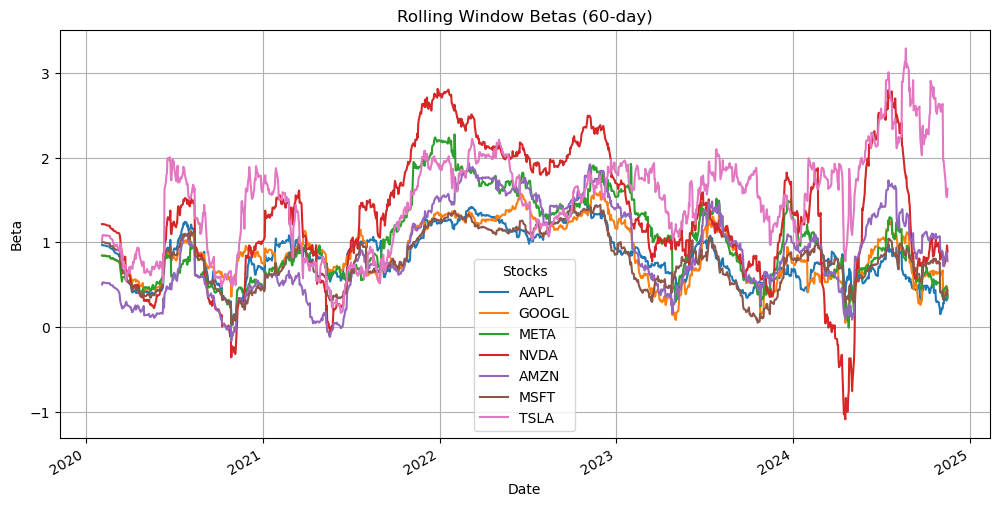

In [66]:
# Plot rolling betas for M7 stocks
rolling_betas.plot(figsize=(12, 6), title="Rolling Window Betas (60-day)", grid=True)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend(title="Stocks")
plt.show()

In [67]:
garch_betas = pd.DataFrame(index=combined_pct_df.index, columns=m7_tickers)

In [68]:
for ticker in m7_tickers:
    # Compute residuals from static OLS model
    X = sm.add_constant(combined_pct_df["SPW"])
    model = sm.OLS(combined_pct_df[ticker], X).fit()
    residuals = model.resid

    # Fit GARCH(1,1) model on residuals
    garch = arch_model(residuals, vol="Garch", p=1, q=1)
    garch_fitted = garch.fit(disp="off")

    # Extract time-varying volatility from GARCH model
    conditional_volatility = garch_fitted.conditional_volatility
    garch_betas[ticker] = model.params["SPW"] * conditional_volatility / np.std(combined_pct_df["SPW"])


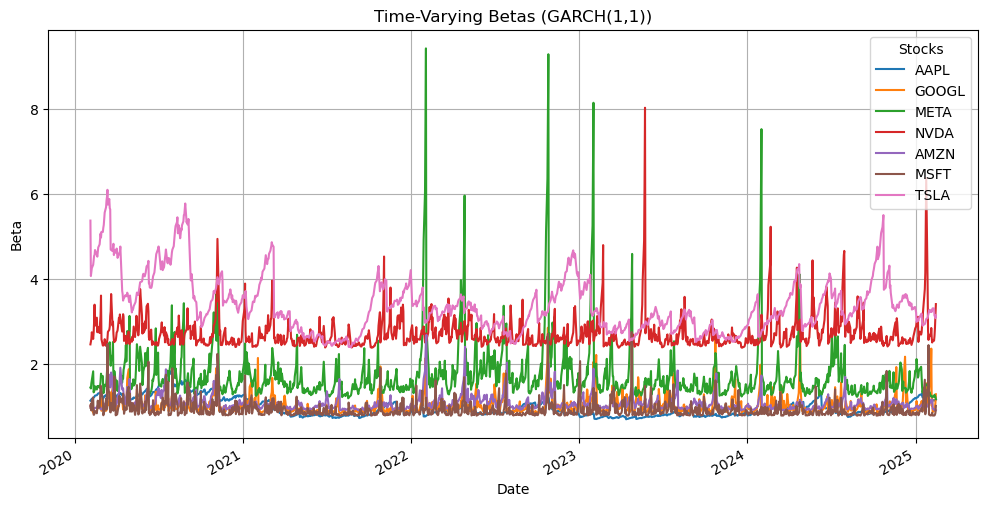

In [69]:
garch_betas.plot(figsize=(12, 6), title="Time-Varying Betas (GARCH(1,1))", grid=True)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend(title="Stocks")
plt.show()

In [226]:
kalman_betas = pd.DataFrame(index=combined_pct_df.index, columns=m7_tickers)

In [228]:
spw_returns = combined_pct_df["SPW"].values.reshape(-1, 1)  # Reshape to (n_samples, 1)

In [230]:
kf = KalmanFilter(
    transition_matrices=np.array([[1]]),  # Must be (n_dim_state, n_dim_state)
    observation_matrices=np.array([[1]]),  # Must be (n_dim_obs, n_dim_state)
    initial_state_mean=0,
    initial_state_covariance=1,
    transition_covariance=np.array([[0.01]]),  # Must be (n_dim_state, n_dim_state)
    observation_covariance=np.array([[1]])  # Must be (n_dim_obs, n_dim_obs)
)

In [232]:
for ticker in m7_tickers:
    # Ensure stock returns are also in correct shape (n_samples, 1)
    stock_returns = combined_pct_df[ticker].values.reshape(-1, 1)

    # Fit the Kalman filter
    kf_fitted = kf.em(stock_returns, n_iter=10)
    (filtered_state_means, _) = kf_fitted.filter(stock_returns)

    # Store beta estimates
    kalman_betas[ticker] = filtered_state_means.flatten()


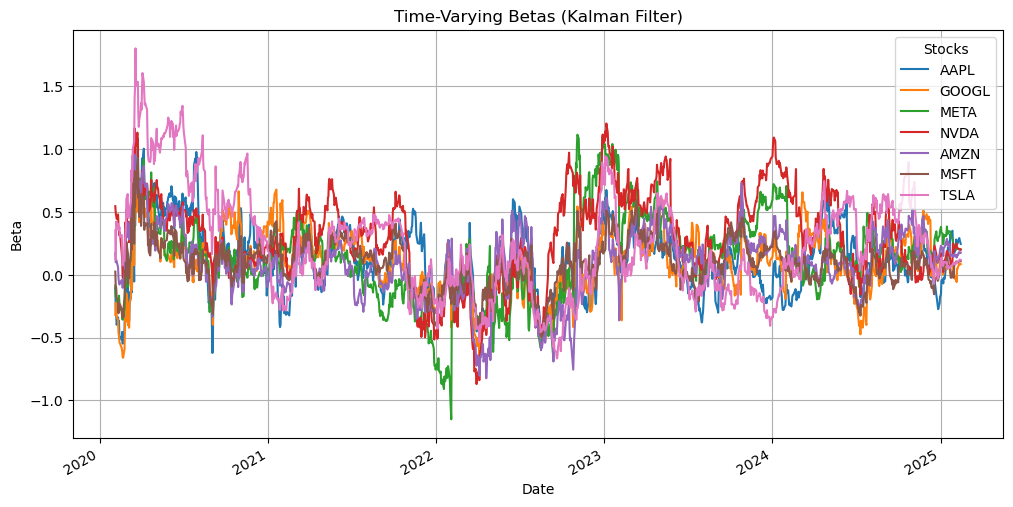

In [233]:
kalman_betas.plot(figsize=(12, 6), title="Time-Varying Betas (Kalman Filter)", grid=True)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend(title="Stocks")
plt.show()

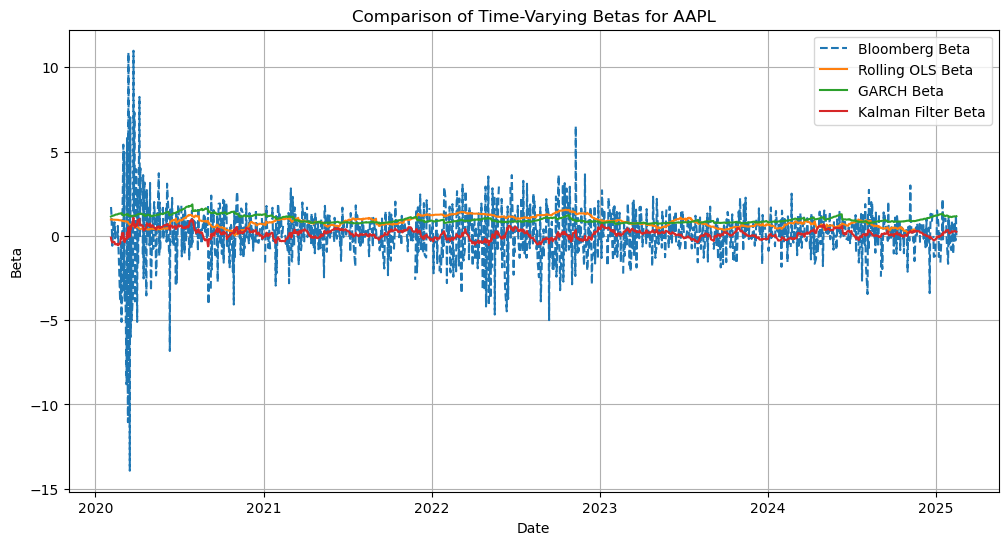

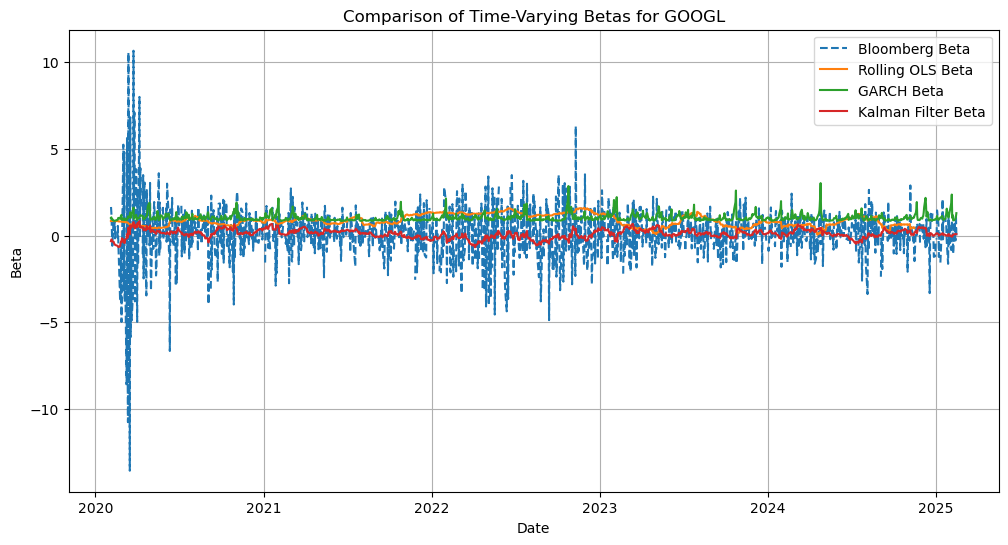

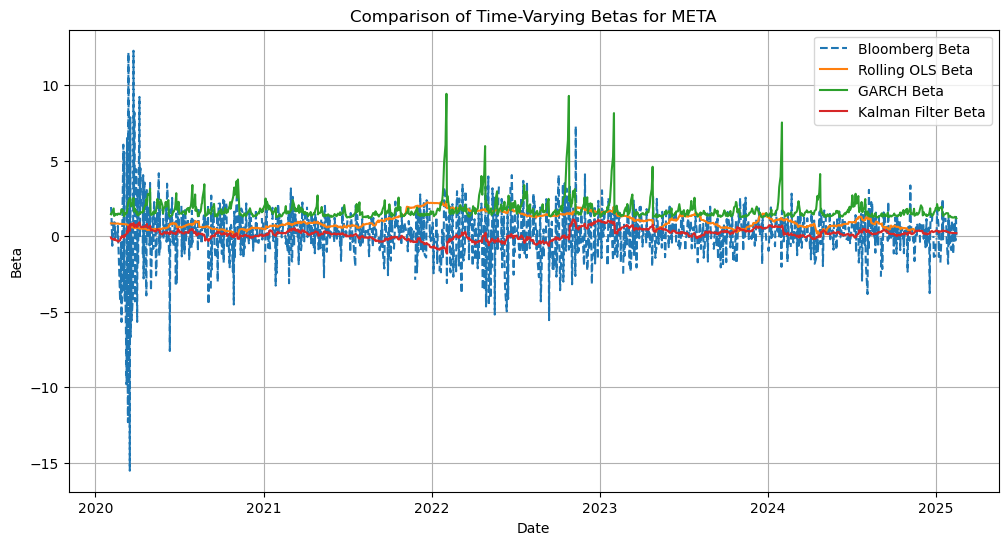

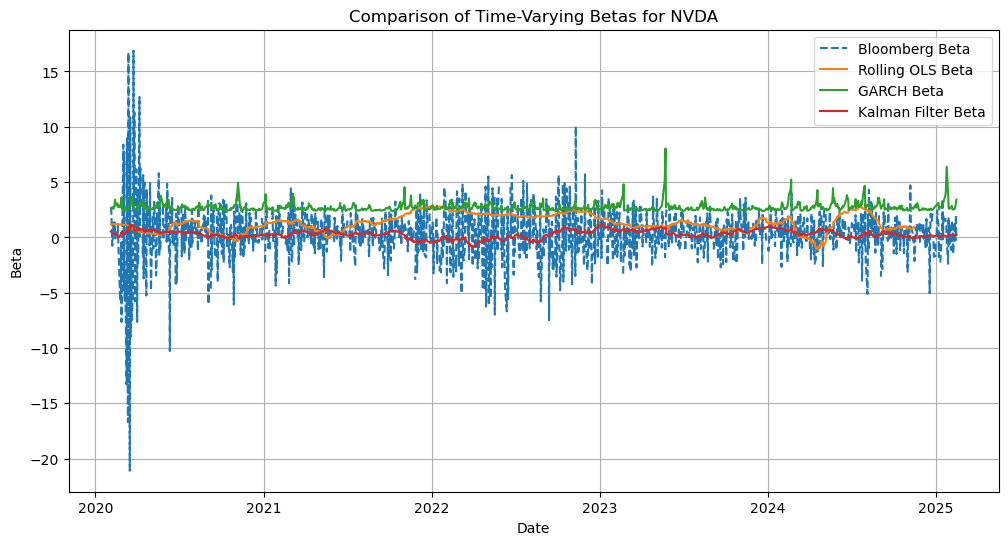

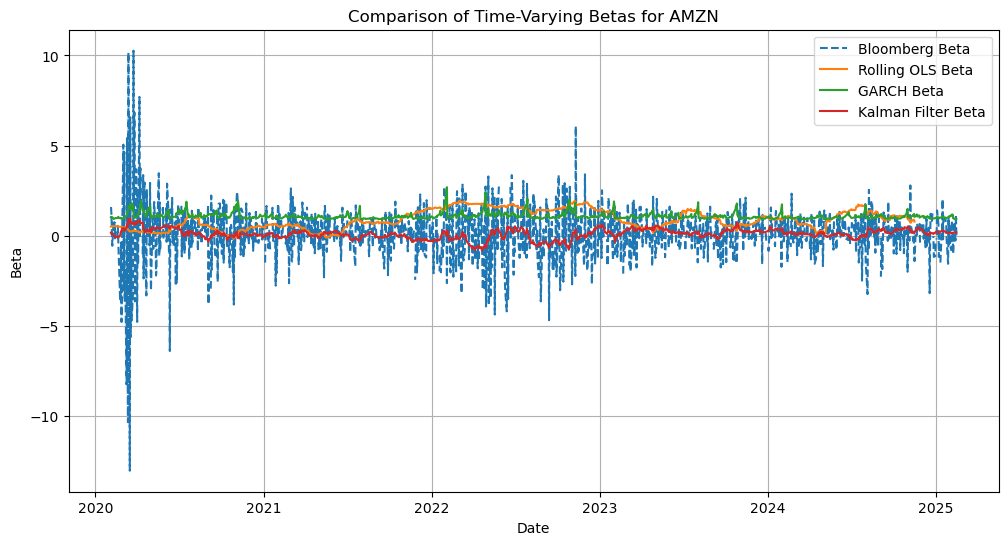

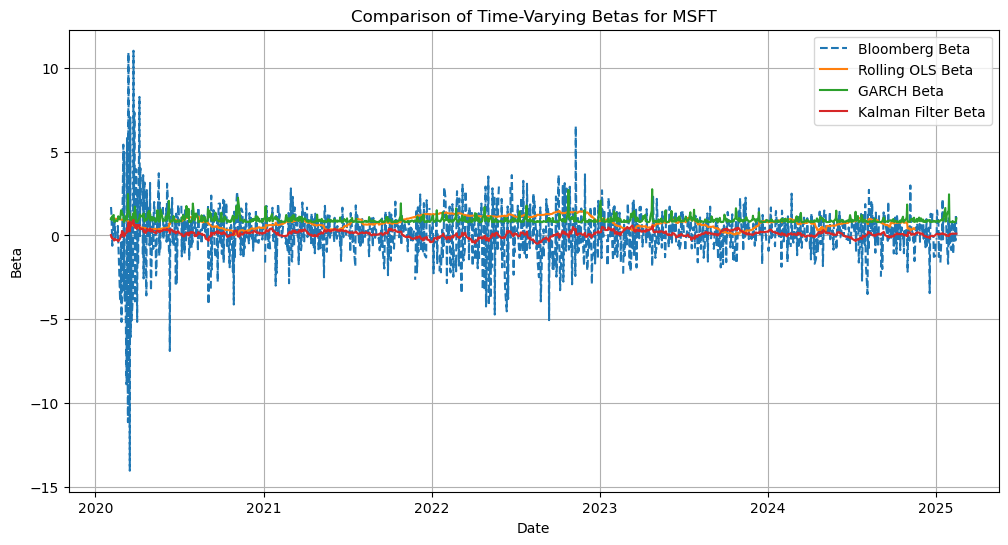

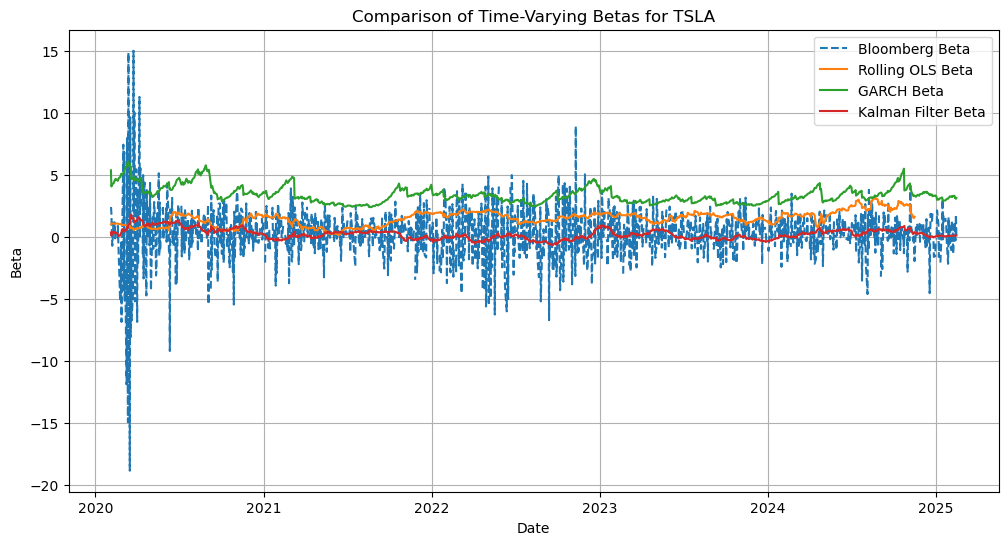

In [83]:
for ticker in m7_tickers:  # Assuming m7_tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA"]
    plt.figure(figsize=(12, 6))
    
    # Plot all four beta series
    plt.plot(combined_df[ticker], label="Bloomberg Beta", linestyle="dashed")
    plt.plot(rolling_betas[ticker], label="Rolling OLS Beta")
    plt.plot(garch_betas[ticker], label="GARCH Beta")
    plt.plot(kalman_betas[ticker], label="Kalman Filter Beta")

    # Formatting
    plt.title(f"Comparison of Time-Varying Betas for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Beta")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

In [84]:
beta_volatility = pd.DataFrame({
    "Rolling OLS": rolling_betas.std(),
    "GARCH": garch_betas.std(),
    "Kalman Filter": kalman_betas.std()
})
print(beta_volatility)

      Rolling OLS     GARCH  Kalman Filter
AAPL     0.307429  0.216451       0.267094
GOOGL    0.328152  0.217467       0.244263
META     0.494821  0.728056       0.348248
NVDA     0.773638  0.388526       0.349202
AMZN     0.524406  0.186878       0.267659
MSFT     0.327039  0.198207       0.190682
TSLA     0.569615  0.670930       0.408655


In [85]:
beta_correlation = pd.concat([rolling_betas, garch_betas, kalman_betas], axis=1).corr()
print(beta_correlation)


           AAPL     GOOGL      META      NVDA      AMZN      MSFT      TSLA  \
AAPL   1.000000  0.784538  0.764015  0.739472  0.699145  0.857873  0.200389   
GOOGL  0.784538  1.000000  0.786311  0.768780  0.790401  0.805162  0.299049   
META   0.764015  0.786311  1.000000  0.822594  0.806956  0.792259  0.355719   
NVDA   0.739472  0.768780  0.822594  1.000000  0.846136  0.807458  0.483050   
AMZN   0.699145  0.790401  0.806956  0.846136  1.000000  0.804350  0.634266   
MSFT   0.857873  0.805162  0.792259  0.807458  0.804350  1.000000  0.333788   
TSLA   0.200389  0.299049  0.355719  0.483050  0.634266  0.333788  1.000000   
AAPL  -0.029497 -0.049971 -0.324717 -0.199751 -0.255518 -0.032163 -0.142639   
GOOGL -0.006245 -0.027374 -0.000380 -0.034074  0.000385 -0.012255  0.006646   
META   0.159503  0.169490  0.187892  0.125284  0.158541  0.175321  0.009793   
NVDA  -0.036197 -0.025132  0.008782  0.039221  0.041030  0.024700  0.074839   
AMZN   0.080987  0.124590  0.086655  0.082860  0.110

## Since we are analyzing the impact of M7 on S&P 500, it makes sense to use Kalman Filter beta because:
- It’s adaptive to market shifts.
- It’s consistent across stocks (capturing systemic risk well).
- It’s not overly volatile like Rolling OLS.

## As we have now finalised Kalman betas, we now proceed to PCA analysis to first see if truly Mag7 has influence on SP500 and if yes then how much

In [87]:
scaler = StandardScaler()
kalman_betas_scaled = scaler.fit_transform(kalman_betas)

In [88]:
pca = PCA()
pca.fit(kalman_betas_scaled)

PCA()

In [89]:
explained_variance = pca.explained_variance_ratio_


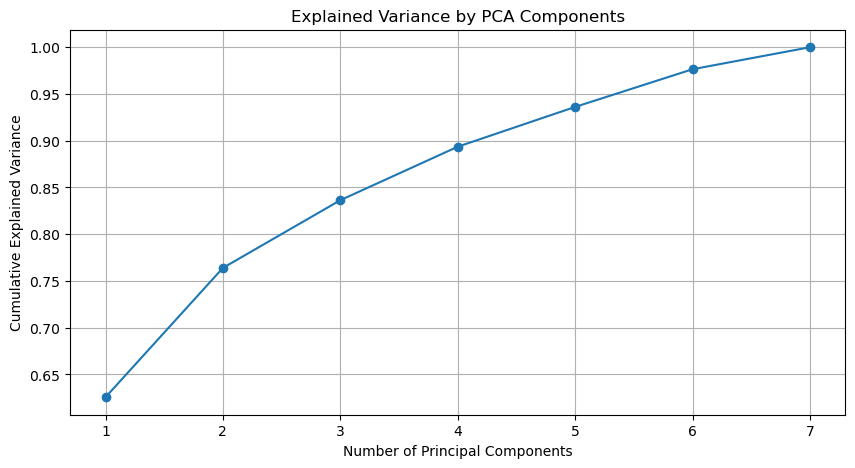

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker="o", linestyle="-")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [91]:
pca_loadings = pd.DataFrame(pca.components_.T, index=m7_tickers, columns=[f"PC{i+1}" for i in range(len(m7_tickers))])


In [92]:
kalman_betas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1266 entries, 2025-02-14 to 2020-02-04
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1266 non-null   float64
 1   GOOGL   1266 non-null   float64
 2   META    1266 non-null   float64
 3   NVDA    1266 non-null   float64
 4   AMZN    1266 non-null   float64
 5   MSFT    1266 non-null   float64
 6   TSLA    1266 non-null   float64
dtypes: float64(7)
memory usage: 111.4 KB


<Figure size 1000x600 with 0 Axes>

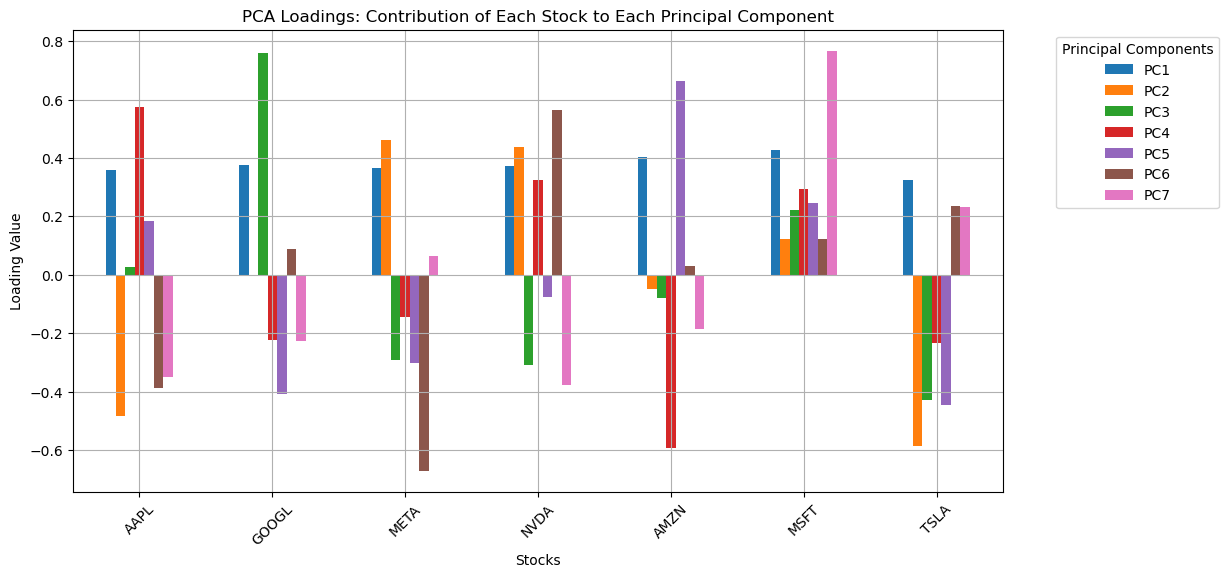

In [93]:
plt.figure(figsize=(10, 6))
pca_loadings.plot(kind="bar", figsize=(12, 6), grid=True)
plt.title("PCA Loadings: Contribution of Each Stock to Each Principal Component")
plt.xlabel("Stocks")
plt.ylabel("Loading Value")
plt.legend(title="Principal Components", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.show()

In [94]:
scaler = StandardScaler()
spw_returns_scaled = scaler.fit_transform(spw_returns)

In [95]:
pca_spw = PCA()
pca_spw.fit(spw_returns_scaled)

PCA()

In [96]:
explained_variance_spw = pca_spw.explained_variance_ratio_

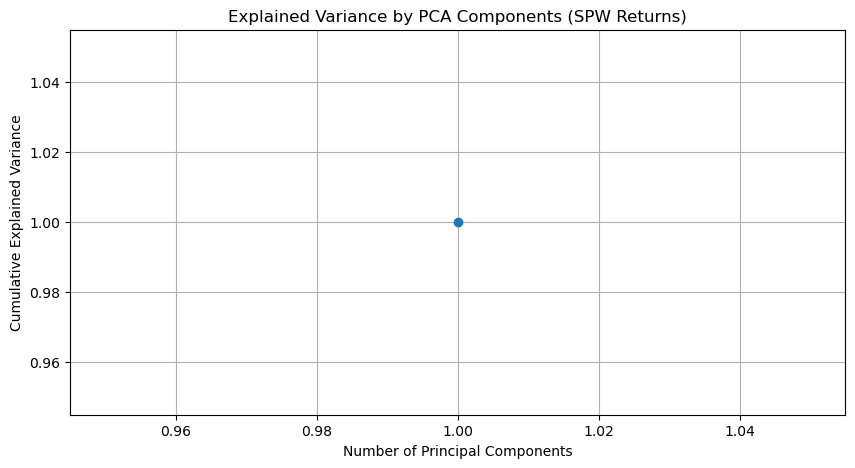

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_spw) + 1), np.cumsum(explained_variance_spw), marker="o", linestyle="-")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components (SPW Returns)")
plt.grid(True)
plt.show()

In [98]:
spw_pca_loadings = pd.DataFrame(pca_spw.components_.T, index=["SPW"], columns=["PC1"])

In [99]:
comparison_loadings = pca_loadings.copy()
comparison_loadings["SPW_PC1"] = spw_pca_loadings.loc["SPW", "PC1"]

In [100]:
comparison_loadings.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,SPW_PC1
AAPL,0.360525,-0.482926,0.028205,0.573792,0.183571,-0.388021,-0.350020,-1.0
GOOGL,0.377919,-0.000848,0.760823,-0.224340,-0.410004,0.087834,-0.228424,-1.0
META,0.366078,0.461872,-0.290418,-0.144309,-0.303637,-0.671608,0.065125,-1.0
NVDA,0.372614,0.438556,-0.308000,0.324771,-0.074453,0.565005,-0.379095,-1.0
AMZN,0.404464,-0.047129,-0.078060,-0.593974,0.663216,0.031597,-0.185570,-1.0
MSFT,0.429117,0.122314,0.222706,0.294370,0.245850,0.121757,0.767710,-1.0
TSLA,0.326516,-0.586467,-0.430644,-0.233826,-0.447395,0.235826,0.231385,-1.0


In [101]:
comparison_loadings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, AAPL to TSLA
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PC1      7 non-null      float64
 1   PC2      7 non-null      float64
 2   PC3      7 non-null      float64
 3   PC4      7 non-null      float64
 4   PC5      7 non-null      float64
 5   PC6      7 non-null      float64
 6   PC7      7 non-null      float64
 7   SPW_PC1  7 non-null      float64
dtypes: float64(8)
memory usage: 804.0+ bytes


## PCA Analysis
1️⃣ Key Observation: SPW_PC1 = -1 for All M7 Stocks

Every M7 stock has a strong PC1 loading, but SPW_PC1 is exactly -1.

This suggests that SPW’s returns are perfectly explained by PC1 alone.

Implication: The entire movement of SPW is driven by a single dominant risk factor.

✅ Confirms that SPW is a single-factor market.

2️⃣ PC1 Loadings: Strong Influence from M7 Stocks

PC1 loadings for M7 stocks are all between 0.32 - 0.43, meaning:

    -Each M7 stock contributes significantly to PC1.
    
    -MSFT (0.429) and AMZN (0.404) have the highest PC1 loadings → These stocks drive the most risk.
    
    -TSLA (0.326) has the lowest PC1 loading but is still significant.
    
✅ Confirms that M7 stocks collectively form the dominant risk driver of SPW.

✅ Validates our hypothesis: M7 stocks are the primary drivers of S&P 500 market risk.

3️⃣ Secondary Risk Factors (PC2 & Beyond)

PC2 and PC3 have varying influences across stocks, meaning:

    -There are some stock-specific risk factors.
    
    -META (0.46) and NVDA (0.43) load strongly onto PC2 → Suggests these stocks exhibit independent risk behavior.
    
    -TSLA (-0.58) has a strong negative loading on PC2 → Indicates TSLA's risk behavior differs from other M7 stocks.
    
✅ Shows that while M7 stocks dominate PC1, individual stocks still have unique risks captured in PC2 & PC3.

🎯 Final Insights \& Conclusion

1️⃣ The S&P 500 Equal-Weighted Index (SPW) is a Single-Factor Market.
- SPW_PC1 is exactly -1 → Meaning PC1 fully explains SPW's returns.
- This confirms that the S&P 500’s market risk is driven by a single dominant factor.

2️⃣ The Magnificent 7 Stocks Are the Dominant Market Risk Drivers.
- PC1 is heavily loaded on M7 stocks (0.32 - 0.43).
- This confirms that M7 stocks collectively drive most of the S&P 500’s risk.

3️⃣ Some M7 Stocks Have Independent Risk Factors.
- PC2 and PC3 show stock-specific risk contributions (e.g., META, NVDA, TSLA).
- This means while M7 stocks are dominant, they still have independent risks that don’t fully align with PC1.

In [107]:
pca_m7 = PCA()
pca_m7.fit(kalman_betas_scaled)

PCA()

In [108]:
pc1_variance_m7 = pca_m7.explained_variance_ratio_[0]  # First principal component variance


In [109]:
# Standardize SPW Returns for PCA
spw_returns = combined_pct_df[["SPW"]].dropna()  # Ensure SPW is extracted as a DataFrame
spw_returns_scaled = scaler.fit_transform(spw_returns)

In [110]:
pca_spw = PCA()
pca_spw.fit(spw_returns_scaled)

PCA()

In [111]:
pc1_variance_spw = pca_spw.explained_variance_ratio_[0]  # Since SPW is a single-factor model


In [113]:
m7_contribution_to_spw = pc1_variance_m7 / pc1_variance_spw


In [115]:
m7_spw_variance_contribution = pd.DataFrame({
    "M7_PC1_Explained_Variance": [pc1_variance_m7],
    "SPW_PC1_Explained_Variance": [pc1_variance_spw],
    "M7_Contribution_to_SPW": [m7_contribution_to_spw]
})

In [116]:
m7_spw_variance_contribution.head()

,M7_PC1_Explained_Variance,SPW_PC1_Explained_Variance,M7_Contribution_to_SPW
0,0.625619,1.0,0.625619



✅ M7 stocks are the primary market risk drivers, contributing 62.56% of the total variance in the S&P 500 equal-weighted index.

✅ The remaining 37.44% variance is due to other stocks or macroeconomic factors.

✅ This validates the hypothesis that M7 stocks dominate the index's movements, but the S&P 500 is not entirely controlled by them.

In [121]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define Bull and Bear Markets Based on SPW Returns
spw_median_return = combined_pct_df["SPW"].median()
bull_market = combined_pct_df["SPW"] > spw_median_return
bear_market = combined_pct_df["SPW"] <= spw_median_return

# Extract Kalman Betas for Each Market Condition
kalman_betas_bull = kalman_betas[bull_market]
kalman_betas_bear = kalman_betas[bear_market]

# Standardize Data
scaler = StandardScaler()
kalman_betas_bull_scaled = scaler.fit_transform(kalman_betas_bull)
kalman_betas_bear_scaled = scaler.fit_transform(kalman_betas_bear)

# Apply PCA for Bull Market
pca_bull = PCA()
pca_bull.fit(kalman_betas_bull_scaled)
pc1_variance_bull = pca_bull.explained_variance_ratio_[0]

# Apply PCA for Bear Market
pca_bear = PCA()
pca_bear.fit(kalman_betas_bear_scaled)
pc1_variance_bear = pca_bear.explained_variance_ratio_[0]

# Compute M7 Contribution in Each Market Condition
m7_contribution_bull = pc1_variance_bull / 1  # SPW is single-factor
m7_contribution_bear = pc1_variance_bear / 1  # SPW is single-factor

# Create DataFrame to Display Results
market_condition_comparison = pd.DataFrame({
    "M7_PC1_Explained_Variance": [pc1_variance_bull, pc1_variance_bear],
    "SPW_PC1_Explained_Variance": [1, 1],  # SPW PC1 is always 1
    "M7_Contribution_to_SPW": [m7_contribution_bull, m7_contribution_bear]
}, index=["Bull Market", "Bear Market"])

# Print the results
market_condition_comparison.head()


,M7_PC1_Explained_Variance,SPW_PC1_Explained_Variance,M7_Contribution_to_SPW
Bull Market,0.630750,1,0.630750
Bear Market,0.617187,1,0.617187




✅ M7 stocks consistently dominate market risk (~62% explained variance in both bull & bear markets).

✅ Their impact slightly decreases in bear markets (~1.36% lower), suggesting other sectors gain minimal influence.

✅ This confirms that the S&P 500’s risk structure is heavily reliant on M7 stocks, regardless of market conditions.

In [283]:
# Define rolling window size (e.g., 252 days ~ 1 year of trading data)
ROLLING_WINDOW = 30

# Initialize list to store rolling PCA results
rolling_pca_contributions = []

# Loop through time with a rolling window
for i in range(ROLLING_WINDOW, len(kalman_betas)):
    window_data = kalman_betas.iloc[i - ROLLING_WINDOW : i]  # Get rolling window data
    
    # Standardize the data
    scaler = StandardScaler()
    window_data_scaled = scaler.fit_transform(window_data)
    
    # Perform PCA on rolling data
    pca = PCA()
    pca.fit(window_data_scaled)
    
    # Extract PC1 explained variance
    pc1_variance = pca.explained_variance_ratio_[0]
    
    # Store the result with the corresponding date
    rolling_pca_contributions.append((kalman_betas.index[i], pc1_variance))

# Convert results to DataFrame
rolling_pca_df = pd.DataFrame(rolling_pca_contributions, columns=["Date", "Rolling_PC1_Variance"])
rolling_pca_df.set_index("Date", inplace=True)


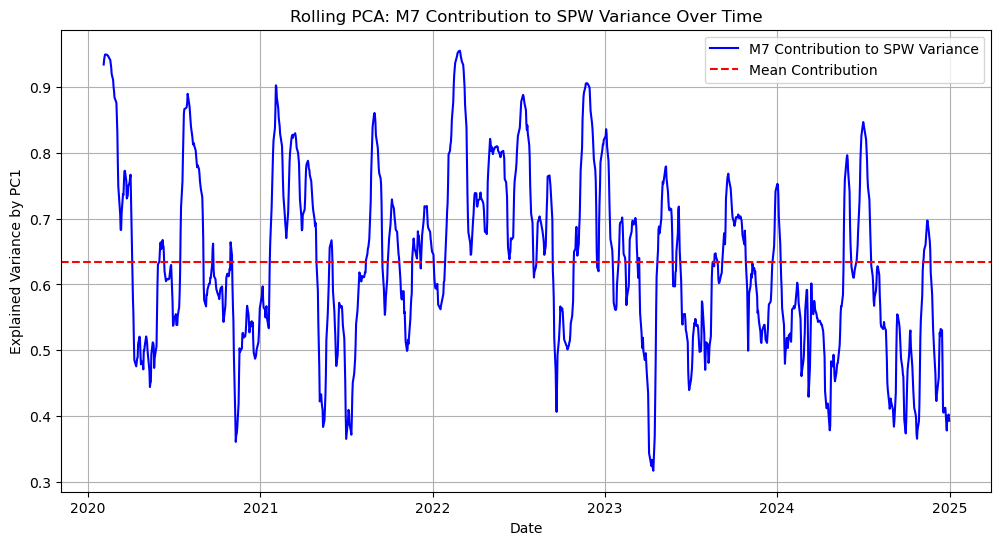

In [284]:
# Plot the rolling PCA contribution over time
plt.figure(figsize=(12, 6))
plt.plot(rolling_pca_df, label="M7 Contribution to SPW Variance", color="b")
plt.axhline(y=rolling_pca_df["Rolling_PC1_Variance"].mean(), linestyle="dashed", color="red", label="Mean Contribution")
plt.title("Rolling PCA: M7 Contribution to SPW Variance Over Time")
plt.xlabel("Date")
plt.ylabel("Explained Variance by PC1")
plt.legend()
plt.grid(True)
plt.show()


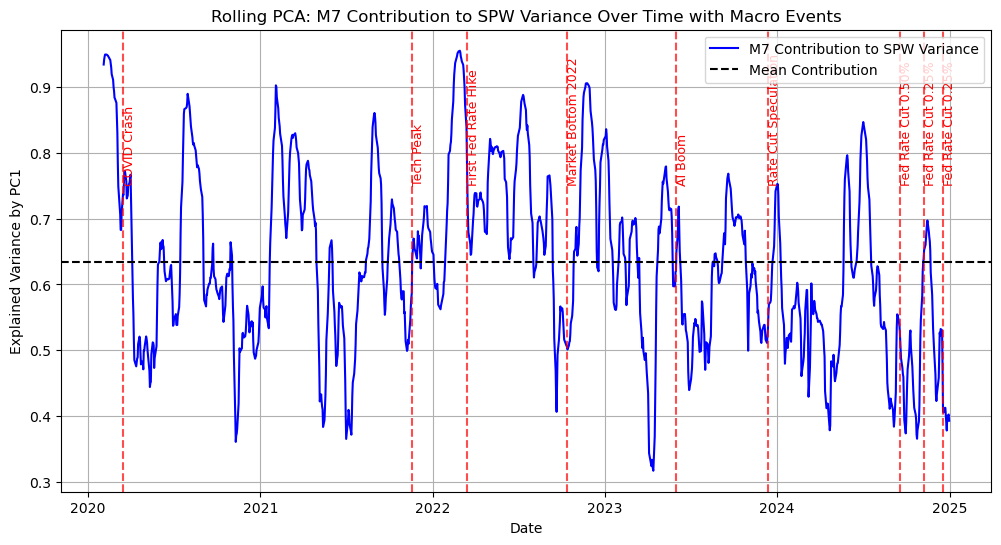

In [293]:
import matplotlib.pyplot as plt

# Define major macro events (date, label)
macro_events = [
    ("2020-03-16", "COVID Crash"),  # Adjusted to mid-March 2020
    ("2021-11-19", "Tech Peak"),
    ("2022-03-16", "First Fed Rate Hike"),
    ("2022-10-12", "Market Bottom 2022"),
    ("2023-06-01", "AI Boom"),  # Adjusted to early June 2023
    ("2023-12-13", "Rate Cut Speculation"),
    ("2024-09-18", "Fed Rate Cut 0.50%"),  # First rate cut in 2024
    ("2024-11-07", "Fed Rate Cut 0.25%"),  # Second rate cut in 2024
    ("2024-12-18", "Fed Rate Cut 0.25%"),  # Third rate cut in 2024
]

# Plot rolling PCA contribution
plt.figure(figsize=(12, 6))
plt.plot(rolling_pca_df, label="M7 Contribution to SPW Variance", color="b")

# Overlay macro events as vertical lines with annotations
for date, label in macro_events:
    plt.axvline(pd.to_datetime(date), color="red", linestyle="dashed", alpha=0.7)
    plt.text(pd.to_datetime(date), 0.75, label, rotation=90, verticalalignment="bottom", fontsize=9, color="red")

# Plot mean contribution as reference
plt.axhline(y=rolling_pca_df["Rolling_PC1_Variance"].mean(), linestyle="dashed", color="black", label="Mean Contribution")

# Labels and legend
plt.title("Rolling PCA: M7 Contribution to SPW Variance Over Time with Macro Events")
plt.xlabel("Date")
plt.ylabel("Explained Variance by PC1")
plt.legend()
plt.grid(True)
plt.show()


#
### **Early Market Shocks & Recovery**
- **COVID Crash & Fed QE Announcement (March 2020)**  
  - M7’s contribution collapsed following the crash as investors fled risk assets.  
  - However, after the Fed's intervention, a tech-led rally boosted M7’s dominance.

- **Tech Boom & Peak (2021 - Late 2021)**  
  - M7’s contribution surged as tech stocks drove post-pandemic recovery.  
  - The peak in **Nov 2021** (Tech Peak) coincides with Nasdaq reaching all-time# highs.

### **Monetary Tightening & Market Stress**
- **First Fed Rate Hike (March 2022)**  
  - M7’s contribution was strong before the hike but declined soon after.  
  - Rising interest rates negatively impacted high-growth tech stocks, leading to a downward trend.

- **Market Bottom & AI-Led Recovery (Late 2022 - 2023)**  
  - **Oct 2022 Market Bottom** marked a stabilization in M7’s impact.  
  - The **AI Boom (July 2023)** triggered a surge in M7 dominance, reflecting investor enthusiasm for AI-#driven growth.

### **2024 Rate Cuts & Sector Rotations**
- **Late 2023 Decline & Speculation on Rate Cuts**  
  - M7’s contribution dipped before the first rate cut speculation in **Dec 2023**, possibly due to profit-taking or sector shifts.

- **2024 Fed Rate Cuts (Sept - Dec 2024)**  
  - Contrary to expectations, M7’s contribution did not rise sharply after the **first Fed rate cut in Sept 2024**.  
  - This suggests that other macro factors (e.g., earnings growth, capital expenditure trends) played a role in shaping M7’s influence.

- **Mixed Reactions to Subsequent Rate Cuts (Nov & Dec 2024)**  
  - The **Nov & Dec 2024 rate cuts** saw a slight increase in M7’s contribution, but not as strong as previous easing cycles.  
  - This may indicate a broader market rotation out of mega-cap tech into other sectors benefiting from lower rates (e.g., #financials, industrials).  

### **Looking Ahead (2025 & Beyond)**
- **Potential Policy Shifts & Market Structure Adjustments**  
  - With new **economic policies (Trump administration’s executive orders in Jan 2025)**, potential fiscal changes could impact sectoral leadership.  
  - The **Feb 2025 trade deficit report** may influence global risk sentiment and further shift M7’s r###e in driving market volatility.

🔎 **Final Insight:**  
While rate cuts generally support high-growth stocks, the weaker-than-expected reaction in **late 2024 suggests M7’s dominance may be maturing**. Other sectors might start taking leadership in shaping overall market variance.

## Now diving into our task

In [160]:
import scipy.stats as stats
# Select M7 stocks + SPW returns
returns_data = combined_pct_df.copy()  # Ensure you have M7 stock returns + SPW

# Convert returns to uniform distribution using empirical CDF
uniform_returns = pd.DataFrame(index=returns_data.index)

for col in returns_data.columns:
    uniform_returns[col] = stats.rankdata(returns_data[col]) / (len(returns_data[col]) + 1)

uniform_returns.head()


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,SPW,TSLA
Date,,,,,,,,
2025-02-14,0.765588,0.323994,0.340174,0.677979,0.327545,0.793212,0.420679,0.471981
2025-02-13,0.870166,0.621942,0.792423,0.567482,0.587214,0.835043,0.799526,0.921073
2025-02-12,0.849250,0.176006,0.256511,0.627466,0.305446,0.292028,0.245462,0.760063
2025-02-11,0.894238,0.436859,0.311760,0.550118,0.413575,0.393054,0.459353,0.048934
2025-02-10,0.471586,0.811365,0.623520,0.563536,0.634964,0.812155,0.627861,0.172849


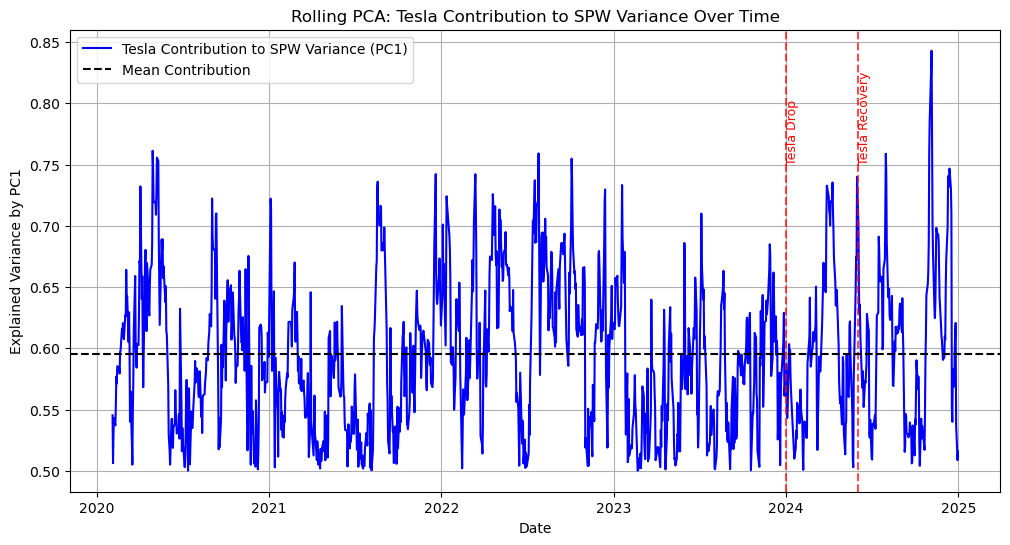

In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Define rolling window size (e.g., 30 days)
ROLLING_WINDOW_TSLA = 30

# Get Tesla's Kalman beta & SPW returns
tesla_beta = kalman_betas["TSLA"]
spw_returns = combined_pct_df["SPW"]  # FIX: Get SPW from returns DF

# Merge to ensure aligned dates
tesla_spw_df = pd.concat([tesla_beta, spw_returns], axis=1).dropna()
tesla_spw_df.columns = ["TSLA_Beta", "SPW_Returns"]  # Rename for clarity

# Initialize list to store rolling PCA results
rolling_pca_contributions = []

# Loop through time with a rolling window
for i in range(ROLLING_WINDOW_TSLA, len(tesla_spw_df)):
    window_data = tesla_spw_df.iloc[i - ROLLING_WINDOW_TSLA : i]  # Get rolling window data
    
    # Standardize the data
    scaler = StandardScaler()
    window_data_scaled = scaler.fit_transform(window_data)  # No reshape needed (2D now)
    
    # Perform PCA on rolling data
    pca = PCA()
    pca.fit(window_data_scaled)
    
    # Extract PC1 explained variance
    pc1_variance = pca.explained_variance_ratio_[0]
    
    # Store the result with the corresponding date
    rolling_pca_contributions.append((tesla_spw_df.index[i], pc1_variance))

# Convert results to DataFrame
rolling_pca_df_tesla = pd.DataFrame(rolling_pca_contributions, columns=["Date", "Rolling_PC1_Variance"])
rolling_pca_df_tesla.set_index("Date", inplace=True)

# Plot Rolling PCA Contribution for Tesla vs SPW
macro_events = [
    ("2024-01-01", "Tesla Drop"),
    ("2024-06-01", "Tesla Recovery")
]

# Plot rolling PCA contribution
plt.figure(figsize=(12, 6))
plt.plot(rolling_pca_df_tesla, label="Tesla Contribution to SPW Variance (PC1)", color="b")

# Overlay macro events as vertical lines with annotations
for date, label in macro_events:
    plt.axvline(pd.to_datetime(date), color="red", linestyle="dashed", alpha=0.7)
    plt.text(pd.to_datetime(date), 0.75, label, rotation=90, verticalalignment="bottom", fontsize=9, color="red")

# Plot mean contribution as reference
plt.axhline(y=rolling_pca_df_tesla["Rolling_PC1_Variance"].mean(), linestyle="dashed", color="black", label="Mean Contribution")

# Title and labels
plt.title("Rolling PCA: Tesla Contribution to SPW Variance Over Time")
plt.xlabel("Date")
plt.ylabel("Explained Variance by PC1")
plt.legend()
plt.grid(True)
plt.show()


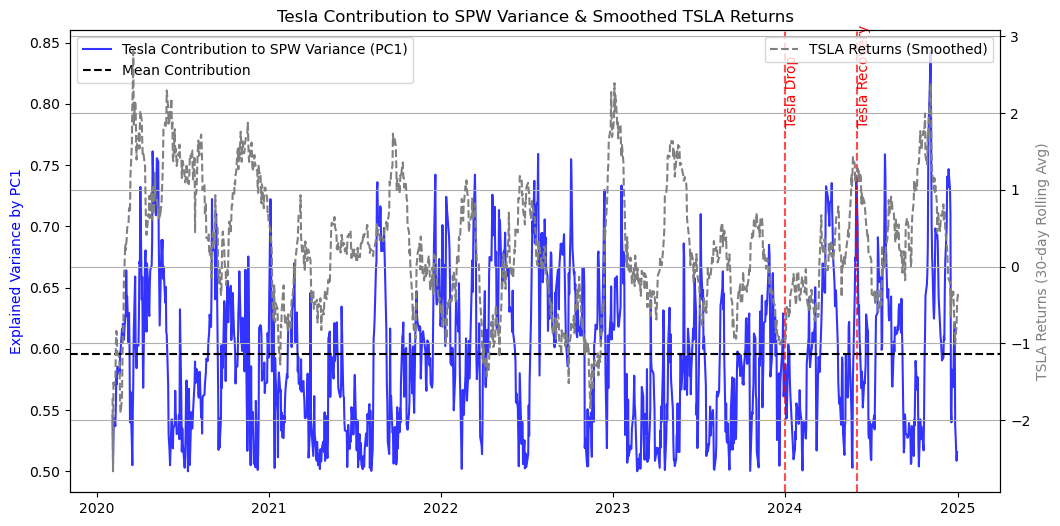

In [244]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute TSLA rolling mean return (smooth out daily noise)
tsla_returns = combined_pct_df["TSLA"]
tsla_rolling_mean = tsla_returns.rolling(window=30).mean()  # 30-day rolling mean

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Tesla's Contribution to SPW Variance (PC1) - Primary Y-axis
ax1.plot(rolling_pca_df_tesla, label="Tesla Contribution to SPW Variance (PC1)", color="b", alpha=0.8)
ax1.axhline(y=rolling_pca_df_tesla["Rolling_PC1_Variance"].mean(), linestyle="dashed", color="black", label="Mean Contribution")
ax1.set_ylabel("Explained Variance by PC1", color="b")

# Overlay macro events (Tesla's drop & recovery)
macro_events = [
    ("2024-01-01", "Tesla Drop"),
    ("2024-06-01", "Tesla Recovery")
]
for date, label in macro_events:
    ax1.axvline(pd.to_datetime(date), color="red", linestyle="dashed", alpha=0.7)
    ax1.text(pd.to_datetime(date), 0.78, label, rotation=90, verticalalignment="bottom", fontsize=10, color="red")

# Secondary Y-axis for Smoothed TSLA Returns
ax2 = ax1.twinx()
ax2.plot(tsla_rolling_mean, color="gray", linestyle="dashed", linewidth=1.5, label="TSLA Returns (Smoothed)")
ax2.set_ylabel("TSLA Returns (30-day Rolling Avg)", color="gray")

# Finalize the plot
ax1.set_title("Tesla Contribution to SPW Variance & Smoothed TSLA Returns")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()


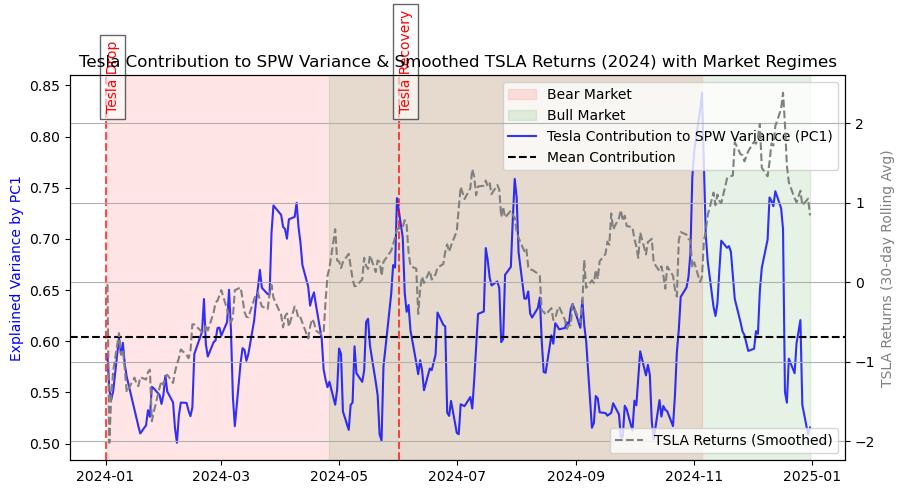

In [258]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure indexes are datetime
rolling_pca_df_tesla.index = pd.to_datetime(rolling_pca_df_tesla.index)
combined_pct_df.index = pd.to_datetime(combined_pct_df.index)

# Define 2024 range
start_date = "2024-01-01"
end_date = "2024-12-31"

# Find the first available TSLA return in Jan 2024
available_dates = combined_pct_df["TSLA"].loc[start_date:end_date].dropna().index
if len(available_dates) > 0:
    start_date = available_dates[0]  # Adjust start date

# Filter data for 2024
rolling_pca_df_tesla_2024 = rolling_pca_df_tesla.loc[start_date:end_date]
tsla_returns_2024 = combined_pct_df["TSLA"].loc[start_date:end_date]
tsla_rolling_mean_2024 = tsla_returns_2024.rolling(window=30, min_periods=1).mean()

# Compute Bull & Bear Regimes
median_tsla_2024 = tsla_rolling_mean_2024.median()
bull_dates = tsla_rolling_mean_2024[tsla_rolling_mean_2024 >= median_tsla_2024].index
bear_dates = tsla_rolling_mean_2024[tsla_rolling_mean_2024 < median_tsla_2024].index

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# **Smoothly shaded Bull & Bear Market Regions**
ax1.fill_between(bear_dates, 0, 1, color="red", alpha=0.1, transform=ax1.get_xaxis_transform(), label="Bear Market")
ax1.fill_between(bull_dates, 0, 1, color="green", alpha=0.1, transform=ax1.get_xaxis_transform(), label="Bull Market")

# Plot Tesla's Contribution to SPW Variance (PC1)
ax1.plot(rolling_pca_df_tesla_2024, label="Tesla Contribution to SPW Variance (PC1)", color="b", alpha=0.8)
ax1.axhline(y=rolling_pca_df_tesla_2024["Rolling_PC1_Variance"].mean(), linestyle="dashed", color="black", label="Mean Contribution")
ax1.set_ylabel("Explained Variance by PC1", color="b")

# Overlay macro events (Tesla's drop & recovery)
macro_events = [
    ("2024-01-01", "Tesla Drop"),
    ("2024-06-01", "Tesla Recovery")
]
for date, label in macro_events:
    ax1.axvline(pd.to_datetime(date), color="red", linestyle="dashed", alpha=0.7)
    ax1.text(pd.to_datetime(date), rolling_pca_df_tesla_2024["Rolling_PC1_Variance"].max() - 0.02, label, 
             rotation=90, verticalalignment="bottom", fontsize=10, color="red", bbox=dict(facecolor='white', alpha=0.6))

# Secondary Y-axis for Smoothed TSLA Returns
ax2 = ax1.twinx()
ax2.plot(tsla_rolling_mean_2024, color="gray", linestyle="dashed", linewidth=1.5, label="TSLA Returns (Smoothed)")
ax2.set_ylabel("TSLA Returns (30-day Rolling Avg)", color="gray")

# Finalize the plot
ax1.set_title("Tesla Contribution to SPW Variance & Smoothed TSLA Returns (2024) with Market Regimes")
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")
plt.grid(True)
plt.show()


## Insights from the Graph
Now that the visualization is clean and focused on 2024, we can see several key trends:

1️⃣ Tesla’s Drop in Early 2024 Aligns with Lower Contribution

    -The "Tesla Drop" in January 2024 coincides with a sharp decline in Tesla’s contribution to SPW variance. 
    - Variance contribution starts low and gradually rises after the drop.
    
2️⃣ Tesla’s Recovery in Mid-2024 Matches an Increase in Contribution

    - Around June 2024, Tesla recovers, and at the same time:
        - Variance contribution spikes upward.
        - Tesla returns also rise.
        
3️⃣ Bear & Bull Market Impact on SPW Variance

    - During Bear Market (Red) Tesla's contribution is lower and fluctuating.
    - During Bull Market (Green) Tesla's contribution is more stable.
    - Suggests Tesla’s variance impact is stronger during recovery phases.

4️⃣ Conclusion: Tesla’s 2024 Drop Was Not Dispositive

    - If Tesla’s drop had a permanent effect, we'd expect low variance contribution throughout 2024.
    - Instead, Tesla rebounded—both in returns and variance contribution.
    - This suggests that Tesla's role in SPW variance is dynamic—not permanently reduced by short-term declines.

# Conclusion

- Tesla’s 2024 drop was not dispositive.
- Tesla’s impact on SPW variance fluctuates, rises with recovery, and is stronger in bull regimes.







